# 1. Developing and Saving the Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import os
import pandas as pd

In [2]:
class Noise2NoiseDataset(Dataset):
    def __init__(self, size, S_max=5.0, D=50, nu=0.25, cm=1.0, V=1.0,
                 random_noise_std=0.56, tropospheric_noise_beta=1.82, tropospheric_noise_scale=1.0,
                 total_days=1460, interval_days=49, f_t=-1, orbit_type='ascending'):
        self.size = size
        self.S_max = S_max
        self.D = D
        self.nu = nu
        self.cm = cm
        self.V = V
        self.random_noise_std = random_noise_std
        self.tropospheric_noise_beta = tropospheric_noise_beta
        self.tropospheric_noise_scale = tropospheric_noise_scale
        self.total_days = total_days
        self.interval_days = interval_days
        self.f_t = f_t
        self.orbit_type = orbit_type

        self.incidence_angle_deg, self.satellite_azimuth_deg = self._get_orbit_geometry()
        self.times = self.get_times()
        
        if len(self.times) == 0:
            self.total_time = 1.0
        elif len(self.times) == 1:
             self.total_time = self.times[0] if self.times[0] > 0 else 1.0
        else:
            self.total_time = self.times[-1] if self.times[-1] > 0 else 1.0
        if self.total_time <=0: self.total_time = 1.0


    def __len__(self):
        return len(self.times)

    def generate_random_noise(self):
        return np.random.normal(loc=0.0, scale=self.random_noise_std, size=self.size)

    def generate_tropospheric_noise(self):
        noise = np.fft.fft2(np.random.randn(*self.size))
        ky = np.fft.fftfreq(self.size[0])
        kx = np.fft.fftfreq(self.size[1])
        kx, ky = np.meshgrid(kx, ky)
        k = np.sqrt(kx**2 + ky**2)
        k[0, 0] = 1e-7
        power = k ** (-self.tropospheric_noise_beta)
        frac_noise = np.fft.ifft2(noise * power).real
        std_val = frac_noise.std()
        if std_val > 1e-9:
            frac_noise = (frac_noise - frac_noise.mean()) / std_val
        else:
            frac_noise = frac_noise - frac_noise.mean()
        return frac_noise * self.tropospheric_noise_scale

    @staticmethod
    def calculate_los_vector(incidence_angle_deg, satellite_azimuth_deg):
        incidence_angle_rad = np.deg2rad(incidence_angle_deg)
        satellite_azimuth_rad = np.deg2rad(satellite_azimuth_deg)
        look_azimuth_rad = satellite_azimuth_rad + np.pi/2
        l_east = np.sin(incidence_angle_rad) * np.sin(look_azimuth_rad)
        l_north = np.sin(incidence_angle_rad) * np.cos(look_azimuth_rad)
        l_up = np.cos(incidence_angle_rad)
        return np.array([l_east, l_north, l_up])

    def generate_subsidence(self, delta_P):
        y, x = np.indices(self.size)
        cx, cy = self.size[1] // 2, self.size[0] // 2
        r_sq = (x - cx)**2 + (y - cy)**2
        r = np.sqrt(r_sq)
        factor = (-1 / np.pi) * self.cm * (1 - self.nu) * delta_P * self.V
        denominator_base = r**2 + self.D**2
        denominator_base[denominator_base < 1e-9] = 1e-9
        uz = factor * (self.D / (denominator_base**1.5))
        ur = factor * (r / (denominator_base**1.5))
        azimuth = np.arctan2(y - cy, x - cx)
        ux = ur * np.cos(azimuth)
        uy = ur * np.sin(azimuth)
        los_vector_calc = Noise2NoiseDataset.calculate_los_vector(self.incidence_angle_deg, self.satellite_azimuth_deg)
        simulated_interferogram = (ux * los_vector_calc[0]) + \
                                  (uy * los_vector_calc[1]) + \
                                  (uz * los_vector_calc[2])
        return simulated_interferogram

    def get_times(self):
        if self.total_days < 1 or self.interval_days <=0:
             return np.array([1.0])
        return np.arange(1, self.total_days + 1, self.interval_days)

    def _get_clean_subsidence_image(self, t):
        delta_P_final = -self.S_max * ((np.pi * self.D**2) / (self.cm * (1 - self.nu) * self.V))
        current_time_factor = 0.0
        if callable(self.f_t):
            if len(self.times) > 0:
                current_time_factor = self.f_t(t, self.times, self.total_time)
            else:
                current_time_factor = t / self.total_time if self.total_time > 0 else 0
        else: 
            current_time_factor = t / self.total_time if self.total_time > 0 else 0
        delta_P_current = -delta_P_final * current_time_factor
        return self.generate_subsidence(delta_P=delta_P_current)

    def _get_orbit_geometry(self):
        if self.orbit_type == 'ascending': return 40, 15
        elif self.orbit_type == 'descending': return 40, 195
        else: raise ValueError("Invalid orbit type.")

    def __getitem__(self, idx):
        current_time = self.times[idx]
        clean_image = self._get_clean_subsidence_image(current_time)
        noise1_random = self.generate_random_noise()
        noise1_tropo = self.generate_tropospheric_noise()
        noisy_image1 = clean_image + noise1_random + noise1_tropo
        noise2_random = self.generate_random_noise()
        noise2_tropo = self.generate_tropospheric_noise()
        noisy_image2 = clean_image + noise2_random + noise2_tropo
        clean_image_tensor = torch.from_numpy(clean_image.copy()).float().unsqueeze(0)
        noisy_image1_tensor = torch.from_numpy(noisy_image1.copy()).float().unsqueeze(0)
        noisy_image2_tensor = torch.from_numpy(noisy_image2.copy()).float().unsqueeze(0)
        return noisy_image1_tensor, noisy_image2_tensor, clean_image_tensor

# --- Time Evolution Functions ---
def f_linear(t, times_array, total_time_val):
    if total_time_val == 0: return 0
    return t / total_time_val

def f_log(t, times_array, total_time_val):
    if total_time_val <= 0: return 0
    if t <= 0: t = 1e-6 
    min_time_in_series = times_array[0] if len(times_array)>0 and times_array[0] > 0 else 1.0
    adjusted_t = (t - min_time_in_series) + 1
    adjusted_total_time = (total_time_val - min_time_in_series) + 1
    if adjusted_total_time <= 1:
        return 1.0 if t >= total_time_val else (t/total_time_val if total_time_val > 0 else 0)
    val = np.log1p(max(0, adjusted_t-1)) / np.log1p(max(1e-7, adjusted_total_time-1))
    return min(max(0, val), 1.0)

In [4]:
IMG_SIZE = (1500, 1500) # Large image size
S_MAX = 5.0
D_DEPTH = 50
NU = 0.25
CM = 1.0
V_PARAM = 1.0
RANDOM_NOISE_STD = 0.56
TROPOSPHERIC_NOISE_BETA = 1.82
TROPOSPHERIC_NOISE_SCALE = 1.0
TOTAL_DAYS = 1460
INTERVAL_DAYS = 49

# --- Root directory for saving precomputed dataset ---
# IMPORTANT: Change this to your Google Drive path if using Drive
PRECOMPUTED_DATA_ROOT = r"C:\Users\manav\KyodaiNaturalResourceLab\dataset"
# ==============================================================
# PHASE 1: DATA GENERATION AND SAVING (Run this section ONCE)
# ==============================================================
def generate_and_save_data():
    print(f"Starting data generation. Files will be saved to: {PRECOMPUTED_DATA_ROOT}")
    os.makedirs(os.path.join(PRECOMPUTED_DATA_ROOT, 'noisy1'), exist_ok=True)
    os.makedirs(os.path.join(PRECOMPUTED_DATA_ROOT, 'noisy2'), exist_ok=True)
    os.makedirs(os.path.join(PRECOMPUTED_DATA_ROOT, 'clean'), exist_ok=True)

    manifest_data = []
    global_sample_idx = 0

    dataset_configs = [
        {'name': 'lin_asc', 'f_t': -1, 'orbit': 'ascending'},
        {'name': 'log_asc', 'f_t': f_log, 'orbit': 'ascending'},
        {'name': 'lin_desc', 'f_t': -1, 'orbit': 'descending'},
        {'name': 'log_desc', 'f_t': f_log, 'orbit': 'descending'}
    ]

    for config in dataset_configs:
        print(f"Generating data for config: {config['name']}")
        # Instantiate the original dataset for generation
        gen_dataset = Noise2NoiseDataset(
            size=IMG_SIZE, S_max=S_MAX, D=D_DEPTH, nu=NU, cm=CM, V=V_PARAM,
            random_noise_std=RANDOM_NOISE_STD, tropospheric_noise_beta=TROPOSPHERIC_NOISE_BETA,
            tropospheric_noise_scale=TROPOSPHERIC_NOISE_SCALE, total_days=TOTAL_DAYS,
            interval_days=INTERVAL_DAYS, f_t=config['f_t'], orbit_type=config['orbit']
        )
        
        if len(gen_dataset) == 0:
            print(f"Warning: No samples generated for config {config['name']}. Check total_days and interval_days.")
            continue

        for i in range(len(gen_dataset)):
            try:
                noisy1_tensor, noisy2_tensor, clean_tensor = gen_dataset[i]

                # Define file paths (relative to PRECOMPUTED_DATA_ROOT)
                noisy1_fname = os.path.join('noisy1', f'sample_{global_sample_idx:06d}_noisy1.pt')
                noisy2_fname = os.path.join('noisy2', f'sample_{global_sample_idx:06d}_noisy2.pt')
                clean_fname = os.path.join('clean', f'sample_{global_sample_idx:06d}_clean.pt')

                # Save tensors
                torch.save(noisy1_tensor, os.path.join(PRECOMPUTED_DATA_ROOT, noisy1_fname))
                torch.save(noisy2_tensor, os.path.join(PRECOMPUTED_DATA_ROOT, noisy2_fname))
                torch.save(clean_tensor, os.path.join(PRECOMPUTED_DATA_ROOT, clean_fname))

                manifest_data.append({
                    'id': global_sample_idx,
                    'config_name': config['name'],
                    'original_idx_in_config': i,
                    'time_step': gen_dataset.times[i],
                    'noisy1_path': noisy1_fname,
                    'noisy2_path': noisy2_fname,
                    'clean_path': clean_fname
                })
                global_sample_idx += 1
                if global_sample_idx % 10 == 0: # Print progress
                    print(f"Saved sample {global_sample_idx}...")

            except Exception as e:
                print(f"Error generating/saving sample {global_sample_idx} (original index {i} in config {config['name']}): {e}")
                # Optionally, decide if you want to skip or halt on error
                continue
        print(f"Finished generating for config: {config['name']}. Total samples so far: {global_sample_idx}")


    manifest_df = pd.DataFrame(manifest_data)
    manifest_path = os.path.join(PRECOMPUTED_DATA_ROOT, 'manifest.csv')
    manifest_df.to_csv(manifest_path, index=False)
    print(f"Data generation complete. Total samples: {global_sample_idx}. Manifest saved to {manifest_path}")

generate_and_save_data()

Starting data generation. Files will be saved to: C:\Users\manav\KyodaiNaturalResourceLab\dataset
Generating data for config: lin_asc
Saved sample 10...
Saved sample 20...
Saved sample 30...
Finished generating for config: lin_asc. Total samples so far: 30
Generating data for config: log_asc
Saved sample 40...
Saved sample 50...
Saved sample 60...
Finished generating for config: log_asc. Total samples so far: 60
Generating data for config: lin_desc
Saved sample 70...
Saved sample 80...
Saved sample 90...
Finished generating for config: lin_desc. Total samples so far: 90
Generating data for config: log_desc
Saved sample 100...
Saved sample 110...
Saved sample 120...
Finished generating for config: log_desc. Total samples so far: 120
Data generation complete. Total samples: 120. Manifest saved to C:\Users\manav\KyodaiNaturalResourceLab\dataset\manifest.csv


In [4]:
PRECOMPUTED_DATA_ROOT = r"C:\Users\manav\KyodaiNaturalResourceLab\dataset"

class PrecomputedNoise2NoiseDataset(Dataset):
    def __init__(self, manifest_file, root_dir):
        self.root_dir = root_dir
        try:
            self.manifest = pd.read_csv(manifest_file)
        except FileNotFoundError:
            print(f"Error: Manifest file not found at {manifest_file}")
            print("Please ensure you have run the data generation phase first.")
            self.manifest = pd.DataFrame() # Empty dataframe

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        if idx >= len(self.manifest):
            raise IndexError("Index out of bounds")
            
        record = self.manifest.iloc[idx]
        
        noisy1_path = os.path.join(self.root_dir, record['noisy1_path'])
        noisy2_path = os.path.join(self.root_dir, record['noisy2_path'])
        clean_path = os.path.join(self.root_dir, record['clean_path'])

        try:
            noisy1_tensor = torch.load(noisy1_path)
            noisy2_tensor = torch.load(noisy2_path)
            clean_tensor = torch.load(clean_path)
        except FileNotFoundError as e:
            print(f"Error loading file for sample id {record['id']}: {e}")
            # Return dummy data or raise error
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            return dummy_tensor, dummy_tensor, dummy_tensor
        except Exception as e:
            print(f"Generic error loading file for sample id {record['id']}: {e}")
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            return dummy_tensor, dummy_tensor, dummy_tensor


        return noisy1_tensor, noisy2_tensor, clean_tensor

In [7]:
# --- Load manifest and create datasets/dataloaders for training ---
manifest_path = os.path.join(PRECOMPUTED_DATA_ROOT, 'manifest.csv')

# Check if manifest exists before proceeding
if not os.path.exists(manifest_path):
    print(f"Manifest file {manifest_path} not found. Please run the data generation phase first.")
    # You might want to exit or prevent further execution if manifest is missing
    # For now, this will lead to an empty dataset if PrecomputedNoise2NoiseDataset handles it.
    
full_dataset = PrecomputedNoise2NoiseDataset(manifest_file=manifest_path, root_dir=PRECOMPUTED_DATA_ROOT)

train_loader, val_loader, test_loader = None, None, None

if len(full_dataset) > 0:
    total_samples = len(full_dataset)
    indices = list(range(total_samples))
    np.random.shuffle(indices)

    train_ratio = 0.7
    val_ratio = 0.15
    # test_ratio = 0.15 implicitly

    if total_samples < 3:
        train_indices = indices
        val_indices, test_indices = [],[]
    else:
        train_split_idx = int(train_ratio * total_samples)
        val_split_idx = train_split_idx + int(val_ratio * total_samples)
        
        train_indices = indices[:train_split_idx]
        val_indices = indices[train_split_idx:val_split_idx]
        test_indices = indices[val_split_idx:]

        # Ensure all sets have at least one sample if total_samples allows
        if not test_indices and val_indices: test_indices = val_indices[-1:]; val_indices = val_indices[:-1]
        if not val_indices and train_indices: val_indices = train_indices[-1:]; train_indices = train_indices[:-1]


    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)
    test_subset = Subset(full_dataset, test_indices)

    print(f"Total precomputed samples: {total_samples}")
    print(f"Train samples: {len(train_subset)}")
    print(f"Validation samples: {len(val_subset)}")
    print(f"Test samples: {len(test_subset)}")
    
    BATCH_SIZE = 1 # Keep batch size small for 1500x1500 images
    if len(train_subset) > 0:
        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    if len(val_subset) > 0:
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    if len(test_subset) > 0:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

else:
    print("Full dataset is empty. Cannot create data loaders.")

Total precomputed samples: 120
Train samples: 84
Validation samples: 18
Test samples: 18


In [8]:
# --- CNN Model (Simple U-Net like structure) ---
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128]): # Reduced features
        super(SimpleUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for feature in features:
            self.downs.append(self._double_conv(in_channels, feature))
            in_channels = feature
        self.bottleneck = self._double_conv(features[-1], features[-1] * 2)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(self._double_conv(feature * 2, feature))
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _double_conv(self, in_c, out_c):
        conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        )
        return conv

    def forward(self, x):
        skip_connections = []
        for down_conv in self.downs:
            x = down_conv(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](concat_skip)
        return self.final_conv(x)

Using device: cuda


C:\Users\manav\AppData\Local\Temp\ipykernel_15588\2557251388.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda')) # Mixed precision
C:\Users\manav\AppData\Local\Temp\ipykernel_15588\358810313.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_


Starting training...

--- Epoch 1/5 ---
Train Batch 0/84, Loss: 1.3650
Train Batch 10/84, Loss: 1.5249
Train Batch 20/84, Loss: 1.4549
Train Batch 30/84, Loss: 1.3921
Train Batch 40/84, Loss: 1.4038
Train Batch 50/84, Loss: 1.4160
Train Batch 60/84, Loss: 1.4413
Train Batch 70/84, Loss: 1.3494
Train Batch 80/84, Loss: 1.4219
End of Epoch, Avg Training Loss: 1.4422


C:\Users\manav\AppData\Local\Temp\ipykernel_15588\2557251388.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Validation Avg Loss: 1.3829
Saved new best model with val_loss: 1.3829 to best_denoising_model.pth

--- Epoch 2/5 ---
Train Batch 0/84, Loss: 1.3663
Train Batch 10/84, Loss: 1.3414
Train Batch 20/84, Loss: 1.3242
Train Batch 30/84, Loss: 1.3500
Train Batch 40/84, Loss: 1.4217
Train Batch 50/84, Loss: 1.3297
Train Batch 60/84, Loss: 1.3356
Train Batch 70/84, Loss: 1.3283
Train Batch 80/84, Loss: 1.3852
End of Epoch, Avg Training Loss: 1.3531
Validation Avg Loss: 1.3361
Saved new best model with val_loss: 1.3361 to best_denoising_model.pth

--- Epoch 3/5 ---
Train Batch 0/84, Loss: 1.2995
Train Batch 10/84, Loss: 1.3141
Train Batch 20/84, Loss: 1.4014
Train Batch 30/84, Loss: 1.2826
Train Batch 40/84, Loss: 1.3350
Train Batch 50/84, Loss: 1.2657
Train Batch 60/84, Loss: 1.3632
Train Batch 70/84, Loss: 1.3632
Train Batch 80/84, Loss: 1.3936
End of Epoch, Avg Training Loss: 1.3386
Validation Avg Loss: 1.3282
Saved new best model with val_loss: 1.3282 to best_denoising_model.pth

--- Epoch 

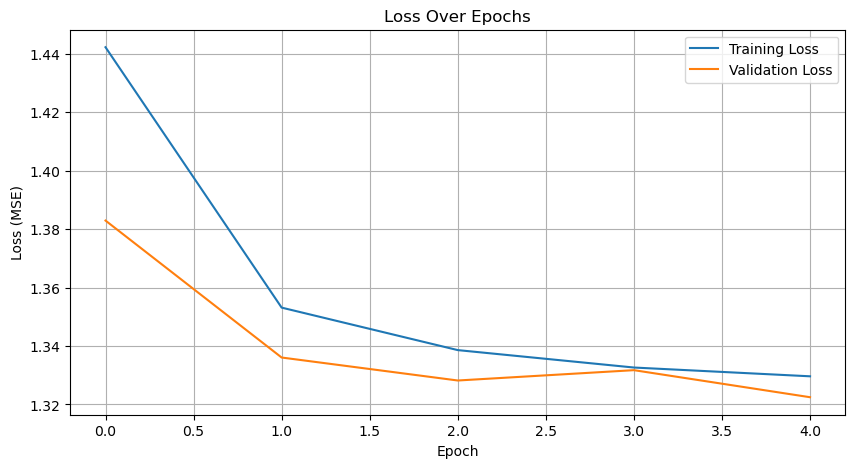


Loading best validation model for display...

Displaying results from Test Set...


C:\Users\manav\AppData\Local\Temp\ipykernel_15588\2557251388.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_denoising_model.pth

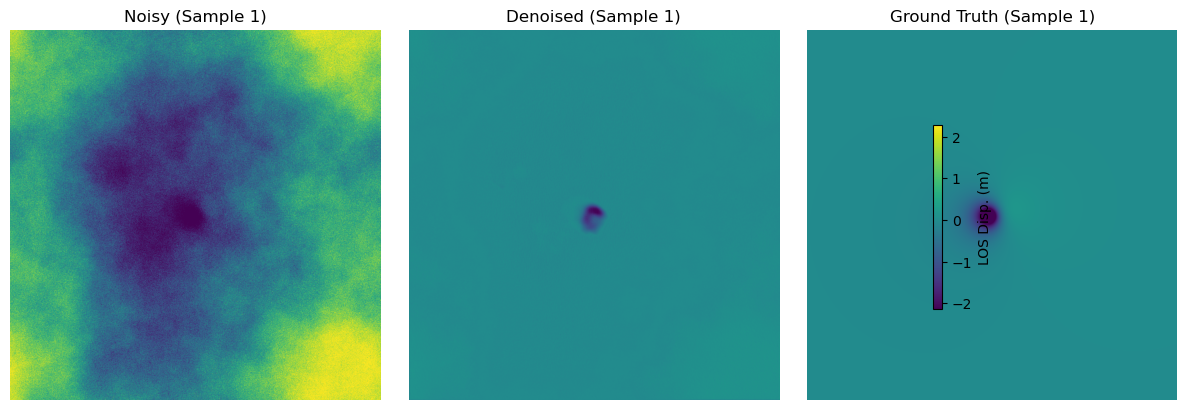

In [9]:
# --- Training Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

MODEL_FEATURES = [16, 32, 64] # Further reduced features for 1500x1500
model = SimpleUNet(in_channels=1, out_channels=1, features=MODEL_FEATURES).to(DEVICE)

LEARNING_RATE = 1e-4 
NUM_EPOCHS = 5 # Start with fewer epochs
WEIGHT_DECAY = 1e-5

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda')) # Mixed precision

# --- Training and Validation Loops (mostly unchanged) ---
def train_one_epoch(loader, model, optimizer, criterion, device, scaler):
    model.train()
    epoch_loss = 0
    if loader is None:
        print("Training loader is None, skipping training epoch.")
        return 0.0
    for batch_idx, (noisy1, noisy2, _) in enumerate(loader):
        noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            denoised_output = model(noisy1)
            loss = criterion(denoised_output, noisy2)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        if batch_idx % 10 == 0: print(f"Train Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")
    if len(loader) == 0: return 0.0
    avg_epoch_loss = epoch_loss / len(loader)
    print(f"End of Epoch, Avg Training Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

def validate_one_epoch(loader, model, criterion, device):
    model.eval()
    epoch_loss = 0
    if loader is None:
        print("Validation loader is None, skipping validation epoch.")
        return float('inf')
    with torch.no_grad():
        for noisy1, noisy2, _ in loader:
            noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                denoised_output = model(noisy1)
                loss = criterion(denoised_output, noisy2)
            epoch_loss += loss.item()
    if len(loader) == 0: return float('inf')
    avg_epoch_loss = epoch_loss / len(loader)
    print(f"Validation Avg Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

print("\nStarting training...")
train_losses, val_losses = [], []
best_val_loss = float('inf')

if train_loader is not None:
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_loss = train_one_epoch(train_loader, model, optimizer, criterion, DEVICE, scaler)
        train_losses.append(train_loss)
        val_loss = float('inf')
        if val_loader is not None:
            val_loss = validate_one_epoch(val_loader, model, criterion, DEVICE)
            val_losses.append(val_loss)
        
        save_path = f"model_epoch_{epoch+1}.pth"
        if val_loss < best_val_loss : # Condition met if val_loader exists and loss improved
            if val_loader is not None: # ensure val_loss is from actual validation
                 best_val_loss = val_loss
                 save_path = "best_denoising_model.pth"
                 print(f"Saved new best model with val_loss: {best_val_loss:.4f} to {save_path}")
        torch.save(model.state_dict(), save_path)
        if val_loader is None: print(f"Saved model checkpoint to {save_path} (no validation).")

else:
    print("Training cannot proceed as train_loader is not available.")

print("\nTraining finished!")

if train_losses or val_losses:
    plt.figure(figsize=(10,5))
    if train_losses: plt.plot(train_losses, label="Training Loss")
    if val_losses: plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)"); plt.title("Loss Over Epochs")
    plt.legend(); plt.grid(True); plt.show()


Loading best validation model for display...

Displaying results from Test Set...


C:\Users\manav\AppData\Local\Temp\ipykernel_15588\2975567080.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_denoising_model.pth"

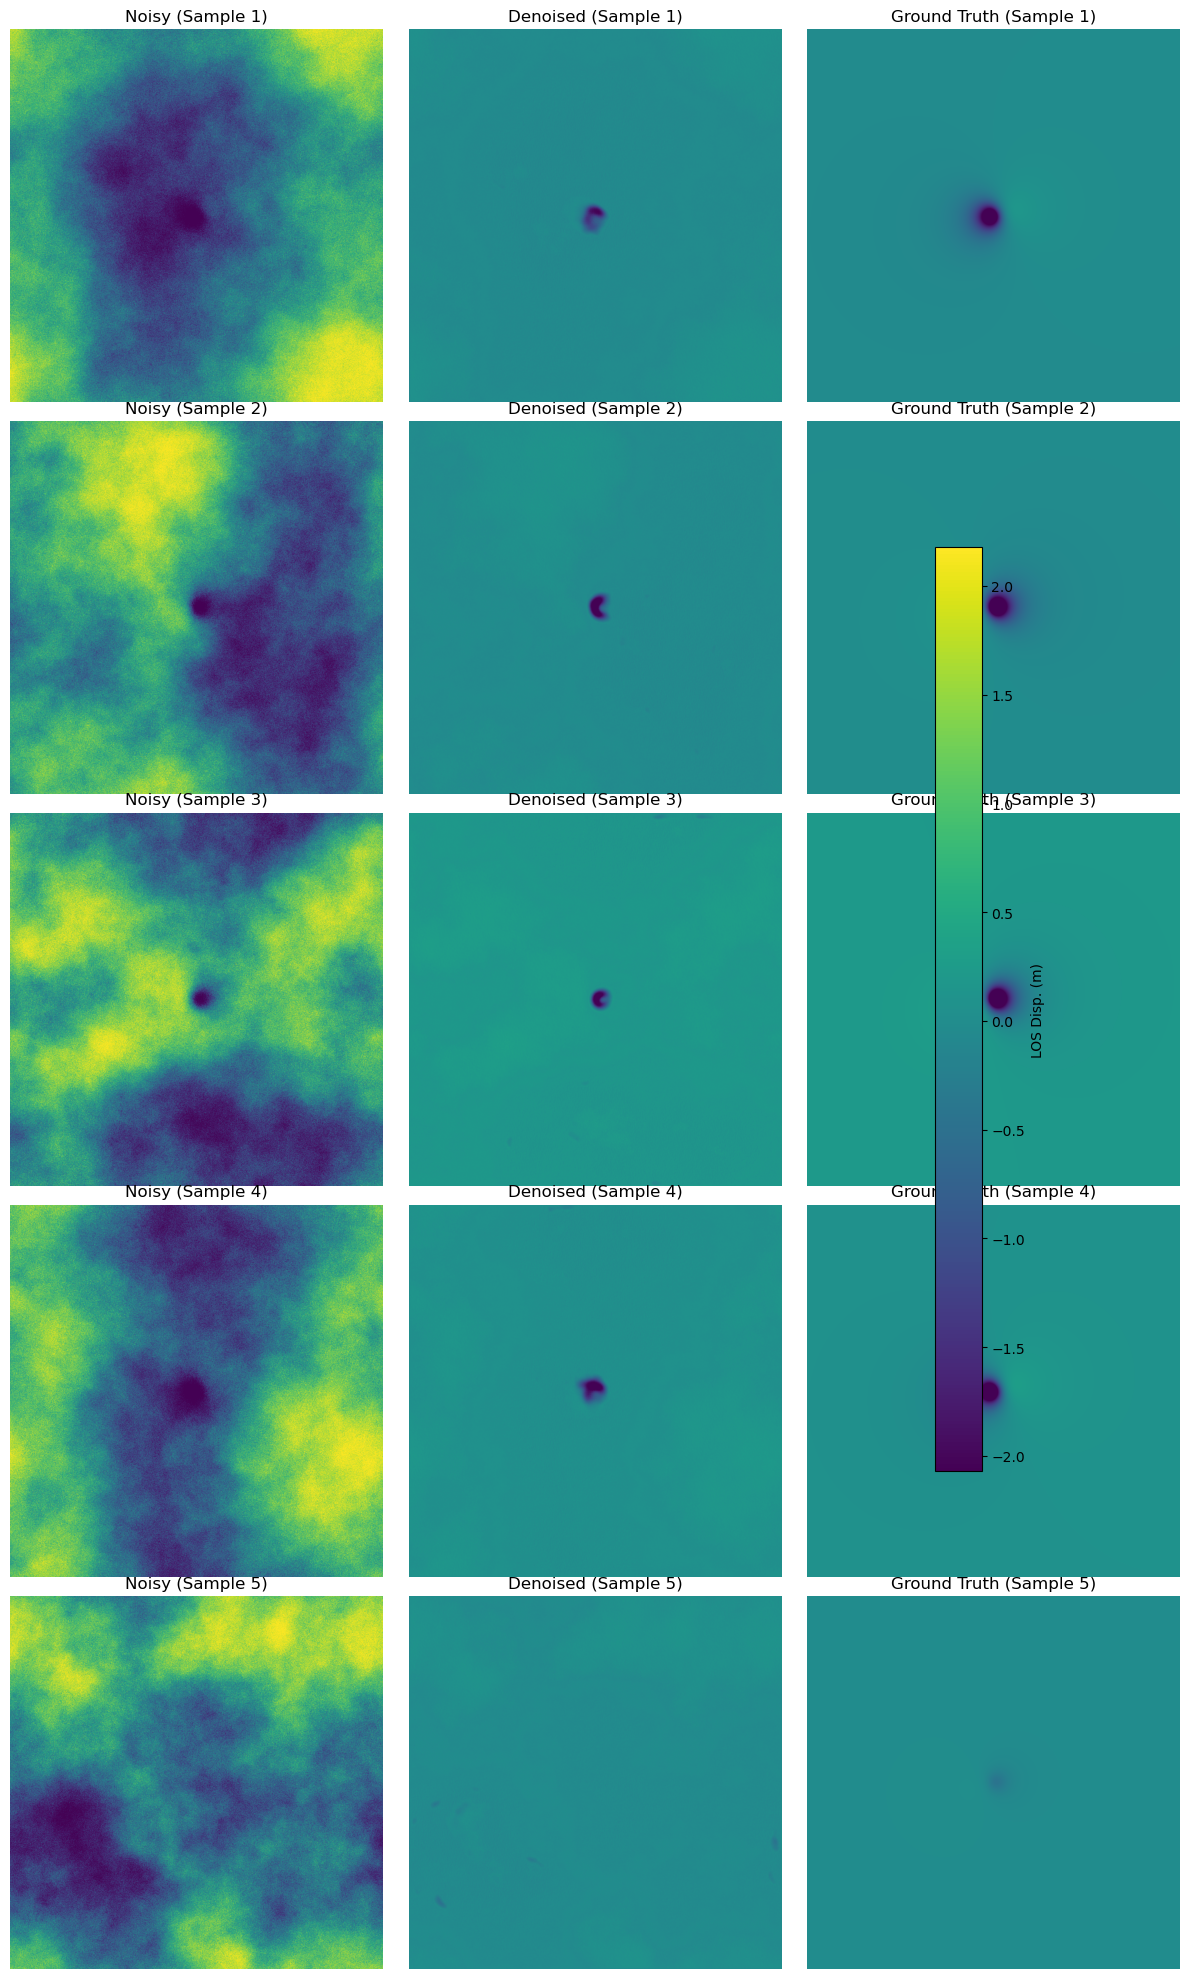

In [10]:
# --- Evaluation & Display (mostly unchanged, uses the new loader) ---
def display_results(model, data_loader, device, num_samples=5): # Default to 1 sample for large images
    if data_loader is None or len(data_loader) == 0:
        print("Data loader for display is None or empty. Skipping display.")
        return
    model.eval().to(device)
    data_iter = iter(data_loader)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    if num_samples == 1: axes = np.array([axes])

    with torch.no_grad():
        for i in range(num_samples):
            try:
                noisy_input, _, ground_truth = next(data_iter)
            except StopIteration: print("Not enough samples."); break
            noisy_input = noisy_input.to(device)
            single_noisy_input = noisy_input[0:1] # Keep batch dim
            single_ground_truth = ground_truth[0].cpu().numpy().squeeze()
            denoised_output = model(single_noisy_input)
            single_denoised_output = denoised_output[0].cpu().numpy().squeeze()
            single_noisy_input_np = single_noisy_input[0].cpu().numpy().squeeze()

            all_vals = np.concatenate([
                single_noisy_input_np.ravel(), single_denoised_output.ravel(), single_ground_truth.ravel()
            ])
            vmin = np.percentile(all_vals, 1) 
            vmax = np.percentile(all_vals, 99)
            if vmin >= vmax: vmin, vmax = all_vals.min(), all_vals.max() # Fallback
            if vmin == vmax: vmin -= 0.1; vmax += 0.1 # Ensure range for flat data

            im = axes[i,0].imshow(single_noisy_input_np,cmap='viridis',vmin=vmin,vmax=vmax)
            axes[i,0].set_title(f"Noisy (Sample {i+1})"); axes[i,0].axis('off')
            im = axes[i,1].imshow(single_denoised_output,cmap='viridis',vmin=vmin,vmax=vmax)
            axes[i,1].set_title(f"Denoised (Sample {i+1})"); axes[i,1].axis('off')
            im = axes[i,2].imshow(single_ground_truth,cmap='viridis',vmin=vmin,vmax=vmax)
            axes[i,2].set_title(f"Ground Truth (Sample {i+1})"); axes[i,2].axis('off')
    if num_samples > 0: fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='LOS Disp. (m)')
    plt.tight_layout(); plt.show()

# Load best model for display
model_loaded_for_display = False
if os.path.exists("best_denoising_model.pth"):
    print("\nLoading best validation model for display...")
    model.load_state_dict(torch.load("best_denoising_model.pth", map_location=DEVICE))
    model_loaded_for_display = True
elif os.path.exists(f"model_epoch_{NUM_EPOCHS}.pth"):
    print(f"\nBest validation model not found. Loading model from last epoch (epoch {NUM_EPOCHS})...")
    model.load_state_dict(torch.load(f"model_epoch_{NUM_EPOCHS}.pth", map_location=DEVICE))
    model_loaded_for_display = True
else:
    print("\nNo saved model weights found for display. Using current model state (if any).")

if model_loaded_for_display or NUM_EPOCHS == 0 : # Display if model was loaded or no training was done (initial state)
    if test_loader is not None and len(test_loader) > 0:
        print("\nDisplaying results from Test Set...")
        display_results(model, test_loader, DEVICE)
    elif val_loader is not None and len(val_loader) > 0:
        print("\nTest Set empty or unavailable. Displaying results from Validation Set...")
        display_results(model, val_loader, DEVICE)
    elif train_loader is not None and len(train_loader) > 0:
        print("\nTest and Validation Sets empty or unavailable. Displaying results from Training Set...")
        display_results(model, train_loader, DEVICE)
    else:
        print("All data loaders are empty. Cannot display results.")